In [ ]:
import ee
import google.oauth2.credentials
import pywt
import folium

# Trigger the authentication flow.
ee.Authenticate(auth_mode='notebook')

# Initialize the library.
ee.Initialize(project='wavelet-project')


def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Define the geographical area and filtering criteria
point = ee.Geometry.Point([-99.9018, 41.4925])
region = point.buffer(10000).bounds()
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
        .filterDate('2022-01-01', '2023-12-31')\
        .filterBounds(region)\
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

if l8.size().getInfo() > 0:
    image = l8.first()
    clipped_image = image.clip(region)
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.5,  # Adjusted for typical scaled TOA reflectance values
        'gamma': 1
    }

    map = folium.Map(location=[41.4925, -99.9018], zoom_start=10)
    map.add_ee_layer(clipped_image, vis_params, "Landsat 8 TOA Image")
    map.add_child(folium.LayerControl())
    display(map) # Explicitly display the map in the notebook
else:
    print("No images found for the specified filters and date range.")

In [3]:
import geopandas as gpd
import ee
ee.Initialize()

# Read the shapefile using Geopandas
gdf = gpd.read_file('training_data_change.shp')

# Function to convert a GeoDataFrame to a FeatureCollection
def geodataframe_to_ee(gdf, ge_column='geometry'):
    features = []
    for _, row in gdf.iterrows():
        geometry = ee.Geometry(row[ge_column].__geo_interface__)
        properties = row.drop(ge_column).to_dict()
        feature = ee.Feature(geometry, properties)
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the GeoDataFrame to a FeatureCollection
training_shp = geodataframe_to_ee(gdf)

# Continue with your operations here...


In [4]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest.
ROI = ee.Geometry.Polygon(
    [[[-74.37518072952373, 41.02358555317697],
      [-74.37518072952373, 40.340423874521555],
      [-73.71600104202373, 40.340423874521555],
      [-73.71600104202373, 41.02358555317697]]])

# Set up date ranges.
before_date_range = ["1989-5-1", "2002-10-01"]
after_date_range = ["2022-5-1", "2023-10-01"]

# Load Landsat imagery.
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
ls5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")

# Function to filter and preprocess images.
def filter_and_scale(img, valid_qa):
    qa_mask = img.select('QA_PIXEL').remap(valid_qa, ee.List.repeat(1, len(valid_qa)), 0)
    img = img.updateMask(qa_mask)
    return img.select('SR_B.*').multiply(0.0000275).add(-0.2)

# Apply functions to image collections.
ls8_processed = ls8.filterDate(*after_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [21824, 21952])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')))
ls5_processed = ls5.filterDate(*before_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [5440, 5568])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B4', 'SR_B3']).rename('ndvi')))

# Create composite images.
after_img = ls8_processed.qualityMosaic('ndvi').select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)
before_img = ls5_processed.qualityMosaic('ndvi').select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)

# Stack images for classification.
multidate_img = ee.Image.cat([before_img, after_img]).rename(['BLUE_b', 'GREEN_b', 'RED_b', 'NIR_b', 'SWIR1_b', 'SWIR2_b', 'NDVI_b', 'BLUE_a', 'GREEN_a', 'RED_a', 'NIR_a', 'SWIR1_a', 'SWIR2_a', 'NDVI_a'])

# Load training data.
training_shp = geodataframe_to_ee(gdf)
training_pts = multidate_img.sampleRegions(
    collection=training_shp,
    properties=['class'],
    scale=30,
    tileScale=4
)

# Random Forest classification.
classifier = ee.Classifier.smileRandomForest(200).train(features=training_pts, classProperty='class', inputProperties=multidate_img.bandNames())
classified = multidate_img.select(multidate_img.bandNames()).classify(classifier).clip(ROI)

# Display the results using geemap.
Map = geemap.Map()
Map.addLayer(after_img, {'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15}, 'After Image')
Map.addLayer(before_img, {'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15}, 'Before Image')
Map.addLayer(classified, {'min': 1, 'max': 4, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Classification')
Map.centerObject(ROI)
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [17]:

# Assuming after_img and ROI are defined
task = ee.batch.Export.image.toDrive(**{
    'image': multidate_img.toFloat(),
    'description': 'after_image_export',
    'folder': 'EarthEngineImages',
    'fileNamePrefix': 'after_image',
    'scale': 30,
    'region': ROI.coordinates().getInfo(),
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
        'cloudOptimized': True
    }
})
task.start()



In [9]:
import rasterio

# Open the image file
with rasterio.open('after_image.tif') as src:
    image = src.read()  # This reads all bands; use src.read(1) to read a specific band
    transform = src.transform

print("Image shape:", image.shape)  # Should be (bands, height, width)



Image shape: (7, 2537, 2447)


In [18]:
import pywt
import numpy as np

def apply_wavelet(image, wavelet='haar', level=5):
    coeffs = pywt.wavedecn(image, wavelet, level=level)
    # Reconstruct the signal from the coefficients
    reconstructed_image = pywt.waverecn(coeffs, wavelet)
    return reconstructed_image

# Assuming the image has multiple bands, apply the transform to each band
transformed_bands = []
for band in image:
    transformed_band = apply_wavelet(band, wavelet='haar', level=1)
    transformed_bands.append(transformed_band)

# Convert list of bands back into a 3D numpy array
transformed_image = np.stack(transformed_bands)



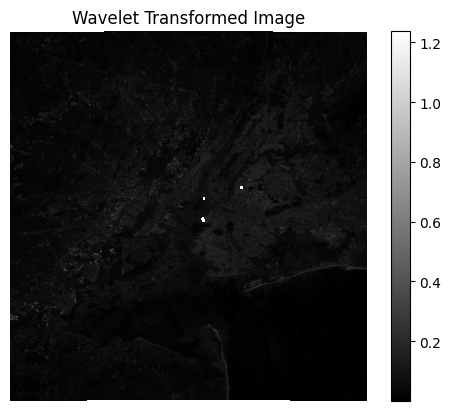

In [21]:
import matplotlib.pyplot as plt

# Choose which band to display, here we display the first band
plt.imshow(transformed_image[2], cmap='gray')
plt.colorbar()
plt.title('Wavelet Transformed Image')
plt.axis('off')  # Hide axis labels
plt.show()


In [29]:
import rasterio

# Open the original image to use its metadata for the new image
with rasterio.open('after_image.tif') as src:
    meta = src.meta.copy()  # Copy the metadata

# Update the metadata to reflect the number of bands and data type
# Note: Ensure the data type matches the dtype of your transformed_image
meta.update({
    'dtype': 'float32',  # Set dtype to float32 or another appropriate based on the transformed data
    'count': transformed_image.shape[0]  # Set number of bands
})

# Save the transformed image to a new TIFF file
with rasterio.open('wavelet_transformed_image.tif', 'w', **meta) as dst:
    for i in range(transformed_image.shape[0]):
        dst.write(transformed_image[i, :, :], i + 1)  # Write each band


In [31]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Load the shapefile
gdf = gpd.read_file('training_data_change.shp')

# Convert polygons to centroids if not already points
if gdf.geometry.iloc[0].geom_type != 'Point':
    gdf['geometry'] = gdf.centroid

print(gdf.head())  # Check the centroid coordinates
def extract_values(gdf, raster_path):
    with rasterio.open(raster_path) as src:
        # List to store feature values
        feature_values = []
        # Iterate through each geometry in the dataframe
        for idx, row in gdf.iterrows():
            # Sample raster at the point location
            for val in src.sample([(row.geometry.x, row.geometry.y)]):
                feature_values.append(val)
        return np.array(feature_values)

# Assuming transformed_image_path is the path to your wavelet-transformed TIFF
transformed_image_path = 'wavelet_transformed_image.tif'
features = extract_values(gdf, transformed_image_path)

# The shape of features array depends on how many bands are in your raster
print(features.shape)



# Prepare labels
labels = gdf['class'].values  # Replace 'label_column' with the actual name of the label column

# Initialize and train the Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features, labels)

# Since there is no test dataset, the model is trained on all available data.
print("Model trained on all available data.")


     id  class                    geometry
0  None      4  POINT (-74.21625 40.59812)
1  None      4  POINT (-74.23870 40.56724)
2  None      4  POINT (-74.25324 40.52763)
3  None      2  POINT (-74.13421 40.58292)
4  None      3  POINT (-74.23653 40.60833)
(25, 7)
Model trained on all available data.


/tmp/ipykernel_22529/506575145.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.centroid


In [33]:
# Read the entire transformed image
with rasterio.open(transformed_image_path) as src:
    # Read all bands and prepare the feature array
    all_bands = src.read()
    # Reshape to (num_pixels, num_bands)
    num_bands, height, width = all_bands.shape
    all_bands_reshaped = all_bands.reshape(num_bands, height * width).T

# Predict the classification for each pixel
predicted_classes = rf.predict(all_bands_reshaped)

# Reshape the predicted classes back to the original image dimensions
classified_image = predicted_classes.reshape((height, width))


# Save the classified image using the metadata from the transformed image
with rasterio.open(transformed_image_path) as src:
    meta = src.meta.copy()
    meta.update({
        'dtype': 'int32',  # Make sure the data type matches the type of `predicted_classes`
        'count': 1  # One band for classified results
    })

    with rasterio.open('classified_image.tif', 'w', **meta) as dst:
        dst.write(classified_image, 1)




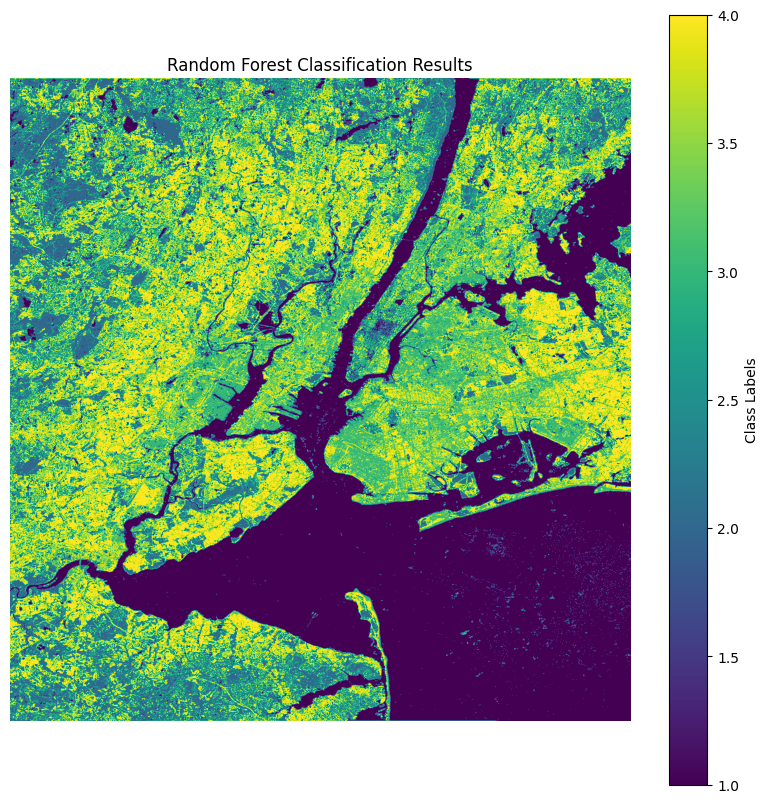

In [34]:
import matplotlib.pyplot as plt

# Load and show the classified image
with rasterio.open('classified_image.tif') as src:
    plt.figure(figsize=(10, 10))
    plt.imshow(src.read(1), cmap='viridis')  # Use a colormap suitable for your classification labels
    plt.colorbar(label='Class Labels')
    plt.title('Random Forest Classification Results')
    plt.axis('off')  # Hide the axis
    plt.show()
